# Bank Term Deposit Prediction Challenge - Binary Classification

### Project Objective

This notebook is part of a Kaggle competition where the main goal is to predict whether a client will subscribe to a bank term deposit.

### Problem Context
Term deposits are important financial products for banks as they provide stable and predictable liquidity. However, marketing campaigns to promote these products can be costly and inefficient if not targeted to the right customers.

### Why is this problem important?

- Resource Optimization: Focus marketing efforts on clients with higher conversion probability
- Effective Segmentation: Identify customer profiles more likely to subscribe to the product
- ROI Improvement: Reduce campaign costs and increase conversion rates

## Solution Approach
In this notebook, we will develop a binary classification model that allows us to:

1. **Exploratory Data Analysis (EDA)**: Understand customer characteristics and data patterns
2. **Data Preprocessing**: Clean and prepare data for modeling
3. **Modeling**: Train and compare different machine learning algorithms
4. **Evaluation**: Validate performance using appropriate classification metrics
5. **Optimization**: Tune hyperparameters to maximize performance

## Exploratory Data Analysis

In this section, I will explore the data provided in the "train.csv" dataset. This will allow me to understand key patterns and characteristics of the data. Additionally, this analysis will give me the information needed to preprocess the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("train.csv",  index_col="id")
print("Train shape", train_df.shape)
train_df.head()

Train shape (750000, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [2]:
print("Train_df info:")
print(f"{train_df.info()}\n") 

Train_df info:
<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB
None



In [3]:
print(f"Number of elements in class '0': {train_df.shape[0] - np.sum(train_df['y'])} ({(train_df.shape[0] - np.sum(train_df['y']))/train_df.shape[0] * 100} %)" ) 
print(f"Number of elements in class '1': {np.sum(train_df['y'])} ({np.sum(train_df['y'])/train_df.shape[0] * 100 } %)") 

Number of elements in class '0': 659512 (87.93493333333333 %)
Number of elements in class '1': 90488 (12.065066666666667 %)


In [4]:
categorical_columns: list[str] = []
numerical_columns: list[str] = []

for column in train_df.columns[:-1]:
    if train_df[column].dtype == "object":
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


### Key insights
- **Class Imbalance Challenge**: The dataset is highly imbalanced with almost 90% of customers not subscribing to the term deposit. This significant imbalance requires careful handling through appropriate evaluation metrics (ROC-AUC, F1-score) and sampling techniques (SMOTE, class weights) to prevent model bias toward the majority class.
- **Data Quality Assessment**: While the dataset contains no traditional missing values, several categorical features include "unknown" entries that require strategic treatment. These "unknown" values may carry predictive signal and should be analyzed before imputation or removal decisions.
- **Mixed Data Types**: The dataset combines numerical features (age, balance, duration) with categorical variables (job, education, contact method). This requires a comprehensive preprocessing strategy with different encoding approaches for categorical variables and appropriate scaling for numerical features to ensure optimal model performance.

### Numerical features

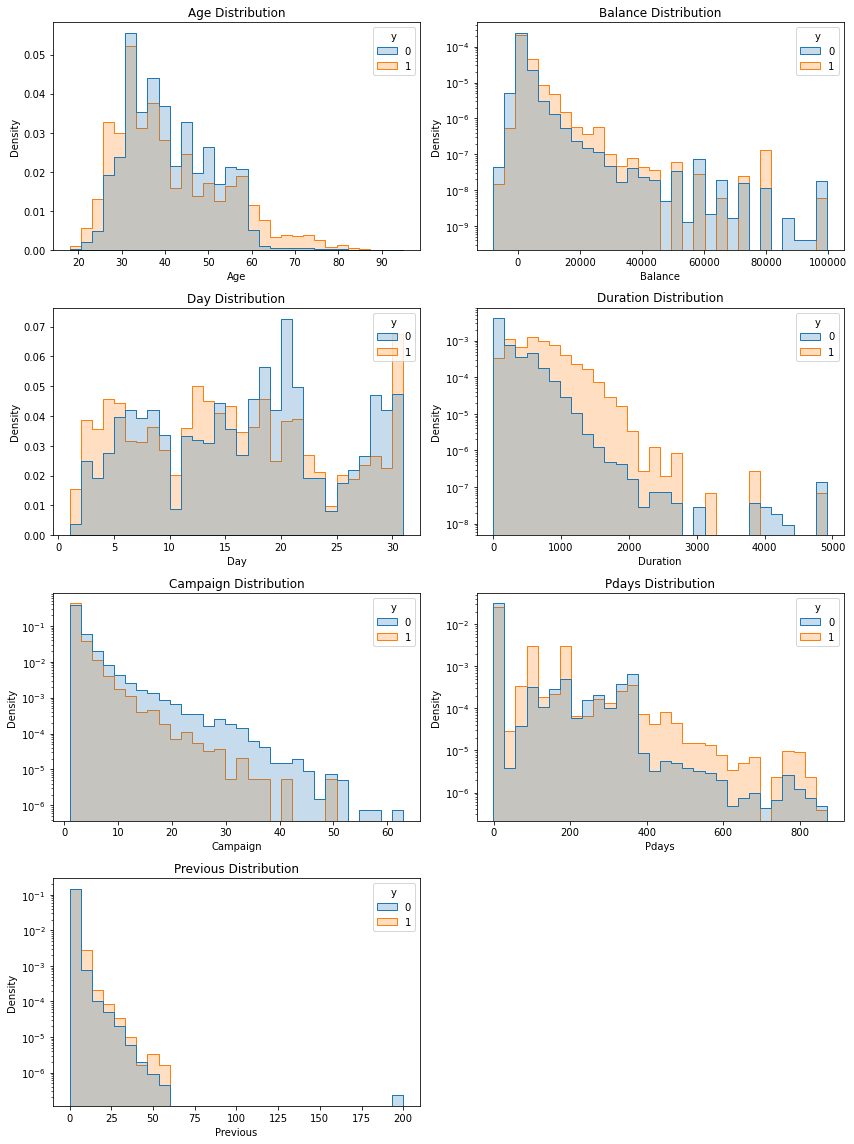

In [5]:
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(data=train_df, x=column, hue='y', bins=30, element='step', stat='density', 
                 common_norm=False,  ax=axes[i])
    col_name = column.replace("_", " ").title()
    axes[i].set_title(f'{col_name} Distribution')
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Density')
    if column != "age" and column != "day":
        axes[i].set_yscale('log')
        
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

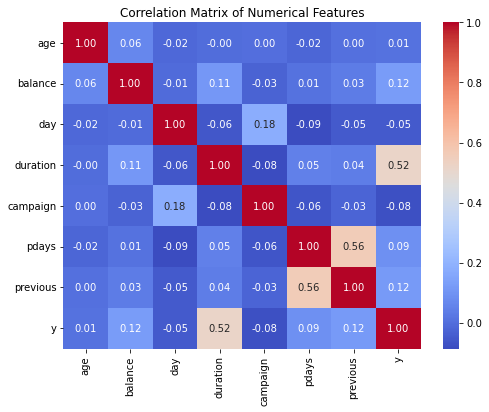

In [6]:
numerical_columns.append('y')
correlation_matrix = train_df[numerical_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### Key insights
- **Limited Linear Relationships**: Most numerical features show weak linear correlation with the target variable, as evidenced by similar distributions across both subscription classes (0 and 1). This suggests that complex, non-linear models may be more effective than linear approaches for capturing predictive patterns.
- **High-Impact Features Identified**: Three numerical features demonstrate clear discriminative power: *Duration* (with higher durations impliying higher conversion rates), *PDays* and *Age* (higher conversion rates in young-adults and older people).
- **Distribution Characteristics**. The majority of numerical features exhibit significant right-skewness rather than normal distributions. This skewness has important implications for model selection and preprocessing if non-tree-based models are choosen.

### Categorical features

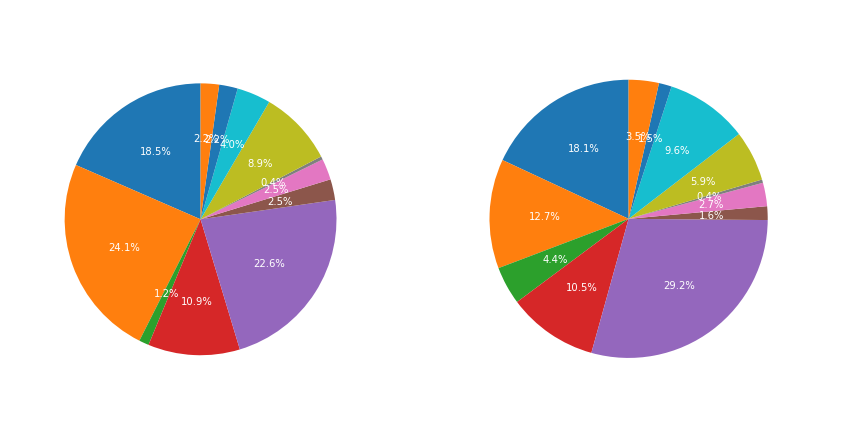

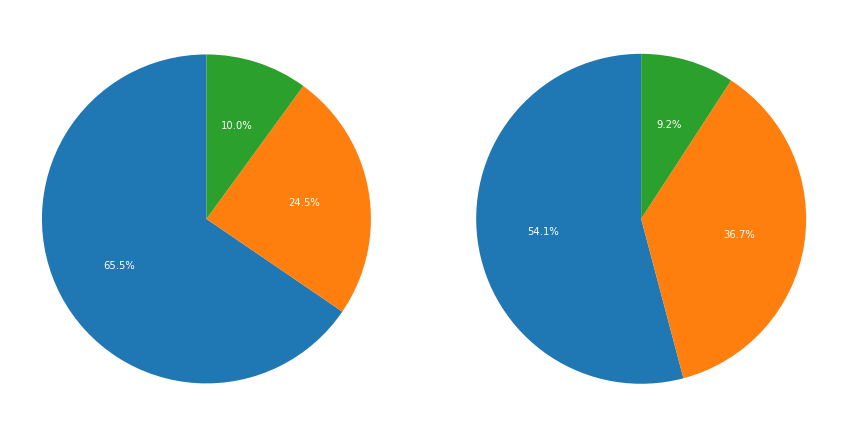

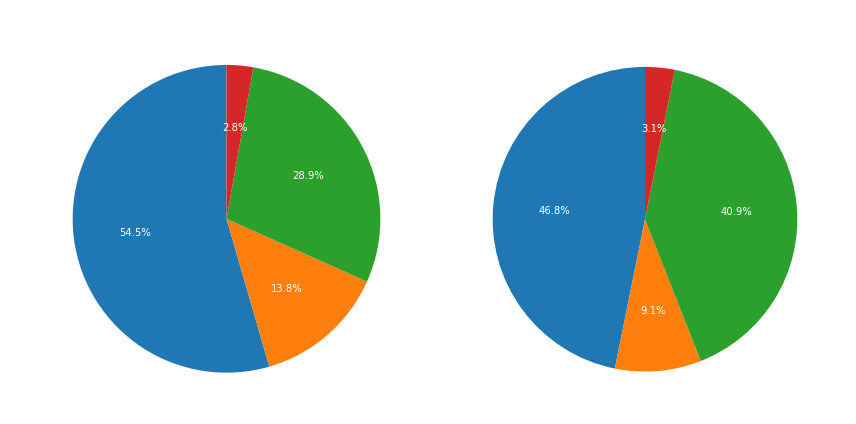

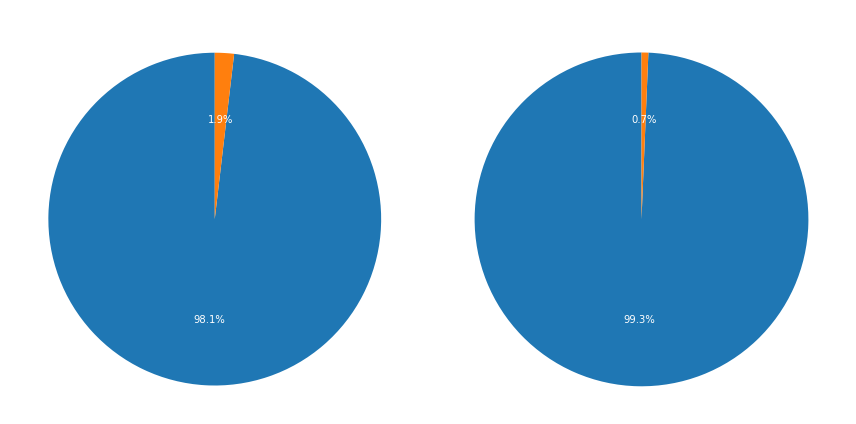

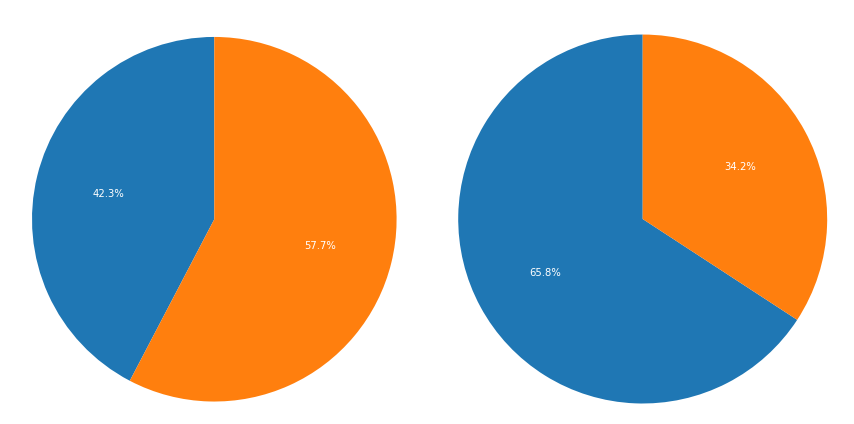

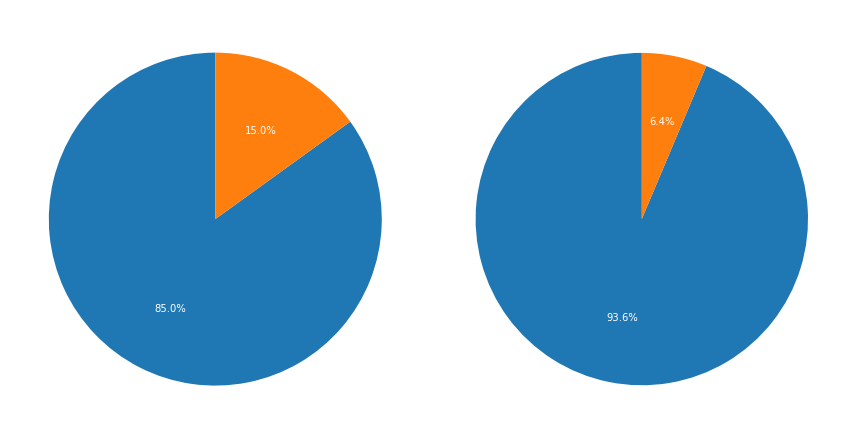

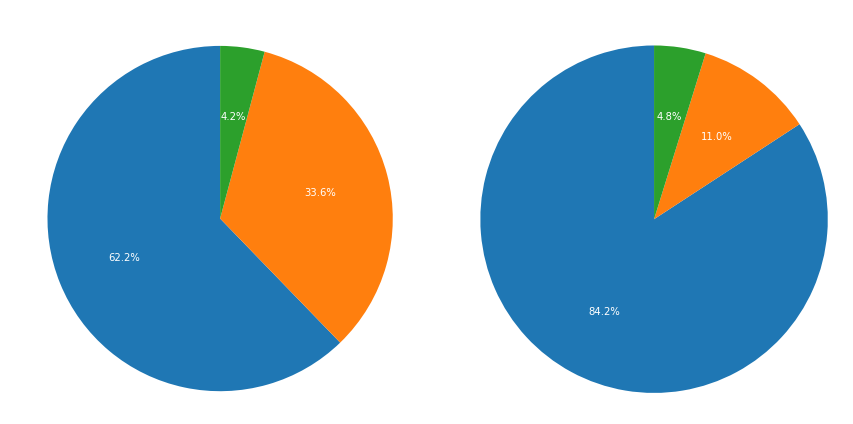

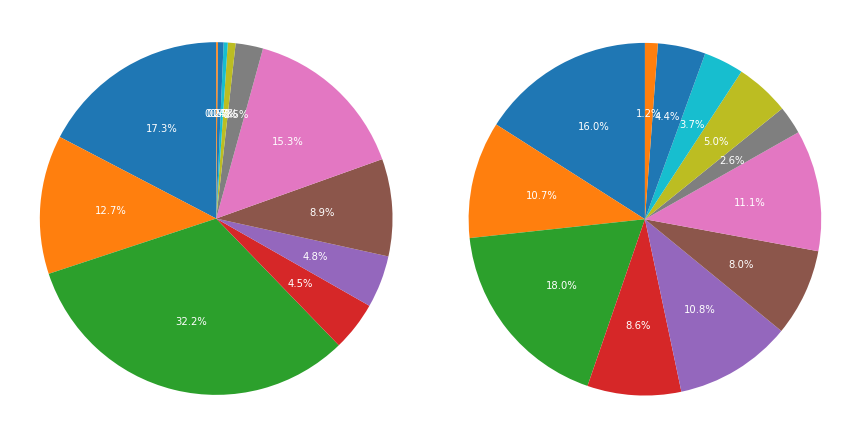

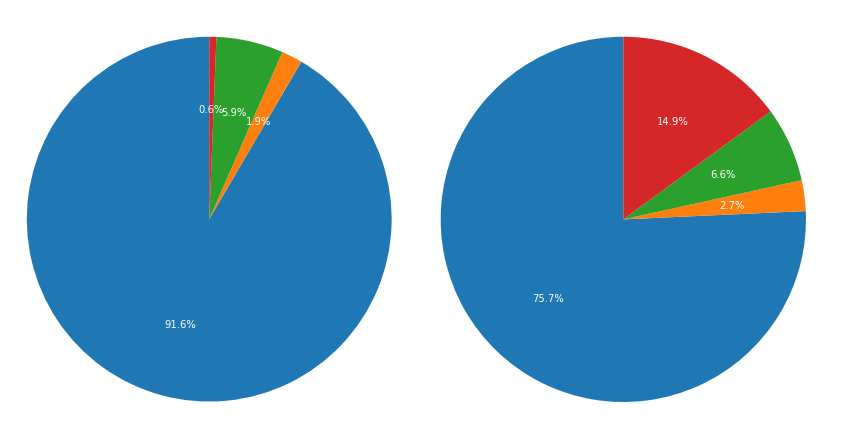

In [7]:
for col in categorical_columns:
    categories = train_df[col].unique()

    counts_y0 = train_df[train_df['y'] == 0][col].value_counts().reindex(categories, fill_value=0)
    counts_y1 = train_df[train_df['y'] == 1][col].value_counts().reindex(categories, fill_value=0)
    colors = plt.cm.tab20.colors[:len(categories)]
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    axes[0].pie(counts_y0, labels=counts_y0.index, autopct="%1.1f%%", startangle=90, textprops={'color':'white'})
    axes[0].set_title(f"{col} when y=0", color="white")
    axes[0].axis('equal')
  
    axes[1].pie(counts_y1, labels=counts_y1.index, autopct="%1.1f%%", startangle=90, textprops={'color':'white'})
    axes[1].set_title(f"{col} when y=1", color="white")
    axes[1].axis('equal')
    
    plt.tight_layout()
    plt.show()


### Key insights

- **Strong Discriminative Power**: Most categorical features exhibit significantly different distributions between subscribers (target = 1) and non-subscribers (target = 0), indicating high predictive potential for the classification task. This validates the strategic focus on advanced categorical encoding techniques.
- **Customer Profile Patterns**: Clear behavioral and demographic patterns emerge when comparing target classes. For example, students and retirees show higher subscription rates. Additionally, people who have been contacted before are more likely to subscribe to the service.
- **Business Intelligence Value**: These distribution differences provide actionable insights for marketing strategy such as customer segmentation based on high-conversion demographic profiles or optimized campaign timing and channel selection.

Customer segmentation based on high-conversion demographic profiles
Optimized campaign timing and channel selection
Resource allocation focused on high-potential customer categories

## Data Preprocessing

In this section, I will preprocess the data to maximize model performance by transforming categorical variables using advanced encoding techniques. Since the final models chosen are tree-based algorithms, no scaling scheme is applied as these models are inherently robust to different feature scales.

The encoding process follows a strategic approach tailored to each feature type:
- **Binary Encoding**: Binary categories ('housing', 'loan', 'default') are directly encoded to numerical values (0 or 1) to maintain their straightforward interpretation.
- **Cyclical Encoding**: The 'month' feature is transformed using sine and cosine functions to capture seasonal patterns and cyclical relationships that linear encoding would miss. This preserves the natural periodicity where December and January are adjacent months.
- **Ordinal Encoding**: Features with natural hierarchical ordering ('marital' and 'education') are encoded using ordinal mapping to preserve their inherent rank relationships. For 'unknown' entries in education, they are assigned a value of -1 to distinguish them from the ordered categories while maintaining tree-based model compatibility.
- **One-Hot Encoding**: Nominal categorical features without natural ordering ("job", "contact", "poutcome") are transformed using one-hot encoding to prevent the model from assuming false ordinal relationships between categories.

In [8]:
def month_encoder(df):
    month_order = ["jan","feb","marzo","apr","may","jun", "jul","aug","sep","oct","nov","dec"]
    month_map = {month: i+1 for i, month in enumerate(month_order)}
    df["month"] = df["month"].map(month_map)
    
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    
    df.drop("month", axis=1)
    return df

def Binary_encoder(df, cols):
    df[cols] = df[cols].map({"no": 0, "yes": 1}.get)
    return df

columns = ['housing', 'loan', 'default']
train_df = Binary_encoder(train_df, columns)
train_df = month_encoder(train_df)
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month_sin,month_cos
id,,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,0,7,0,0,cellular,25,8.0,117,3,-1,0,unknown,0,-8.660254e-01,-0.500000
1,38,blue-collar,married,secondary,0,514,0,0,unknown,18,6.0,185,1,-1,0,unknown,0,1.224647e-16,-1.000000
2,36,blue-collar,married,secondary,0,602,1,0,unknown,14,5.0,111,2,-1,0,unknown,0,5.000000e-01,-0.866025
3,27,student,single,secondary,0,34,1,0,unknown,28,5.0,10,2,-1,0,unknown,0,5.000000e-01,-0.866025
4,26,technician,married,secondary,0,889,1,0,cellular,3,2.0,902,1,-1,0,unknown,1,8.660254e-01,0.500000


In [9]:
train_df = pd.get_dummies(train_df, columns=["job", "contact", "poutcome"], drop_first=True, dtype=int)

edu_map = {"primary": 0, "secondary": 1, "tertiary": 2, "unknown": -1}
train_df["education"] = train_df["education"].map(edu_map)

marital_map = {"single": 0, "married": 1, "divorced": 2}
train_df["marital"] =  train_df["marital"].map(marital_map)

train_df.head()

,age,marital,education,default,balance,housing,loan,day,month,duration,...,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
id,,,,,,,,,,,,,,,,,,,,,
0,42,1,1,0,7,0,0,25,8.0,117,...,0,0,1,0,0,0,0,0,0,1
1,38,1,1,0,514,0,0,18,6.0,185,...,0,0,0,0,0,0,1,0,0,1
2,36,1,1,0,602,1,0,14,5.0,111,...,0,0,0,0,0,0,1,0,0,1
3,27,0,1,0,34,1,0,28,5.0,10,...,0,1,0,0,0,0,1,0,0,1
4,26,1,1,0,889,1,0,3,2.0,902,...,0,0,1,0,0,0,0,0,0,1


## Model trainning


----- Fold 1 -----
XGBM AUC Fold 1: 0.9687
[LightGBM] [Info] Number of positive: 72391, number of negative: 527609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120652 -> initscore=-1.986273
[LightGBM] [Info] Start training from score -1.986273
LGBM AUC Fold 1: 0.9691
Blend AUC Fold 1: 0.9691


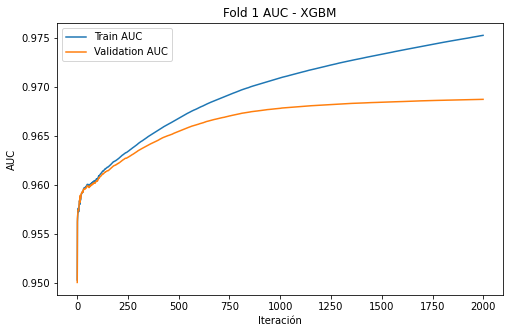

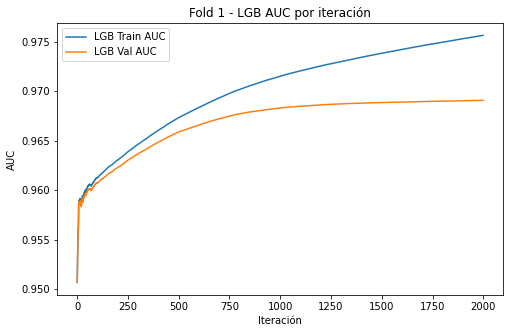


----- Fold 2 -----
XGBM AUC Fold 2: 0.9677
[LightGBM] [Info] Number of positive: 72391, number of negative: 527609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120652 -> initscore=-1.986273
[LightGBM] [Info] Start training from score -1.986273
LGBM AUC Fold 2: 0.9681
Blend AUC Fold 2: 0.9681

----- Fold 3 -----
XGBM AUC Fold 3: 0.9676
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data po

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb

target_variable = 'y'
X = train_df.drop(columns=[target_variable])
y = train_df[target_variable]

params = {"objective": "binary:logistic","eval_metric": "auc","learning_rate": 0.01, "max_leaves": 127,
          "min_child_weight": 1.5, "max_depth": 0, "subsample": 0.85,"colsample_bytree": 0.75,
          "colsample_bynode": 0.85, "grow_policy": "lossguide", "reg_alpha": 2.5, "reg_lambda": 0.8, 
          "n_estimators": 2000, "scale_pos_weight": (len(y) - sum(y)) / sum(y),"tree_method": "hist","n_jobs": 4}

params_lgb = {"objective": "binary","metric": "auc","learning_rate": 0.01, "num_leaves": 127,
    "min_child_samples": 20, "max_depth": -1, "subsample": 0.85,"colsample_bytree": 0.75,
    "reg_alpha": 2.5, "reg_lambda": 0.8, "n_estimators": 2000,
    "scale_pos_weight": (len(y) - sum(y)) / sum(y), "n_jobs": 4, "random_state": 42}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
oof_preds = np.zeros(len(y))

auc_scores_lgb = []
oof_preds_lgb = np.zeros(len(y))

auc_scores_blend = []
oof_preds_blend = np.zeros(len(y))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n----- Fold {fold+1} -----")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(**params, random_state=42, early_stopping_rounds=100)
    
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    preds_xgb = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds_xgb)
    auc_scores.append(auc)
    oof_preds[val_idx] = preds_xgb
    
    print(f"XGBM AUC Fold {fold+1}: {auc:.4f}")
    model2 = lgb.LGBMClassifier(**params_lgb)
    model2.fit(X_train, y_train, eval_set=eval_set, eval_metric="auc")

    preds_lgb = model2.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds_lgb)
    auc_scores_lgb.append(auc)
    print(f"LGBM AUC Fold {fold+1}: {auc:.4f}")
    preds_blend = 0.5 * preds_xgb + 0.5 * preds_lgb
    auc_blend = roc_auc_score(y_val, preds_blend)
    auc_scores_blend.append(auc_blend)
    oof_preds_blend[val_idx] = preds_blend

    print(f"Blend AUC Fold {fold+1}: {auc_blend:.4f}")
    if fold == 0:
        results = model.evals_result()
        plt.figure(figsize=(8,5))
        plt.plot(results['validation_0']['auc'], label='Train AUC')
        plt.plot(results['validation_1']['auc'], label='Validation AUC')
        plt.title(f'Fold {fold+1} AUC - XGBM')
        plt.xlabel('Iteración')
        plt.ylabel('AUC')
        plt.legend()
        plt.show()
        
        results_lgb = model2.evals_result_
        plt.figure(figsize=(8,5))
        plt.plot(results_lgb['training']['auc'], label='LGB Train AUC')
        plt.plot(results_lgb['valid_1']['auc'], label='LGB Val AUC')
        plt.title(f'Fold {fold+1} - LGB AUC por iteración')
        plt.xlabel('Iteración')
        plt.ylabel('AUC')
        plt.legend()
        plt.show()

print("\n===== Final results =====")
print(f"XGB AUC mean: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"LGB AUC mean: {np.mean(auc_scores_lgb):.4f} ± {np.std(auc_scores_lgb):.4f}")
print(f"Blend AUC mean: {np.mean(auc_scores_blend):.4f} ± {np.std(auc_scores_blend):.4f}")

The blending model produces a better result than the individuals model. However, this model is still quite simple and the combination of both models can be improved by training a stacking model.

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

voter = VotingClassifier(estimators=[('xgb', xgb.XGBClassifier(**params)), 
                                     ('lgb', lgb.LGBMClassifier(**params_lgb))],
                         voting='soft' )
cv_auc = cross_val_score(voter, X, y,cv=kf,scoring="roc_auc",n_jobs=4)

print("===== CV Results VotingClassifier =====")
print(f"AUC mean: {cv_auc.mean():.4f}")
print(f"AUC std: {cv_auc.std():.4f}")
print(f"AUC folds: {cv_auc}")

===== CV Results VotingClassifier =====
AUC mean: 0.9685
AUC std: 0.0005
AUC folds: [0.96908169 0.96805623 0.96791438 0.96898134 0.9682262 ]


## Hyperparameter tunning

In [22]:
import optuna
from sklearn.model_selection import cross_val_score

X = train_df.drop(columns=[target_variable])
y = train_df[target_variable]

def objective(trial):
    params_xgb = {
        "max_depth": 0,
        "max_leaves": trial.suggest_int("max_leaves", 100, 255),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0, step=0.5),
        "learning_rate": 0.01,
        "n_estimators": 4000,
        "tree_method": "hist",
        "reg_alpha": 2.5,
        "reg_lambda": 0.8,
        "eval_metric": "auc",
        "scale_pos_weight": (len(y) - sum(y)) / sum(y),
        "n_jobs": 4
    }
    
    params_lgb = {
        "num_leaves": trial.suggest_int("num_leaves", 100, 255),
        "learning_rate": 0.01,
        "min_child_samples":  trial.suggest_int("min_child_samples", 10, 100),
        "max_depth": 0,
        "n_estimators":  4000,
        "reg_alpha": 2.5,
        "reg_lambda": 0.8,
        "objective": "binary",
        "metric": "auc",
        "scale_pos_weight": (len(y) - sum(y)) / sum(y),
        "n_jobs": 4
    }
    
    voter = VotingClassifier(
        estimators=[('xgb', xgb.XGBClassifier(**params_xgb)),('lgb', lgb.LGBMClassifier(**params_lgb))],
        voting="soft")
    
    auc = cross_val_score(voter, X, y, cv=3, scoring="roc_auc", n_jobs=4).mean()
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)
print("Best AUC:", study.best_value)

[I 2025-09-04 13:51:57,971] A new study created in memory with name: no-name-be4aaf95-5b08-46c4-9309-88b6624e3cf7
[W 2025-09-04 14:17:40,778] Trial 0 failed with parameters: {'max_leaves': 188, 'min_child_weight': 4.0, 'num_leaves': 246, 'min_child_samples': 17} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\juanc\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\juanc\AppData\Local\Temp/ipykernel_38084/2660602216.py", line 40, in objective
    auc = cross_val_score(voter, X, y, cv=3, scoring="roc_auc", n_jobs=4).mean()
  File "C:\Users\juanc\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\juanc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 445, in cross_val_score
    cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
  Fil

KeyboardInterrupt: 

### Final model trainning

In this section, I will train the final model with all the data in the "train.csv" dataset. Additionally, I will explore the features most relevant in the classification problem for each model.

In [13]:
final_model = xgb.XGBClassifier(**params, random_state=42)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.85,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
              max_leaves=127, min_child_weight=1.5, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=4,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [14]:
final_model_lgb =  lgb.LGBMClassifier(**params_lgb)
final_model_lgb.fit(X, y)

[LightGBM] [Info] Number of positive: 90488, number of negative: 659512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120651 -> initscore=-1.986283
[LightGBM] [Info] Start training from score -1.986283


LGBMClassifier(colsample_bytree=0.75, learning_rate=0.01, metric='auc',
               n_estimators=2000, n_jobs=4, num_leaves=127, objective='binary',
               random_state=42, reg_alpha=2.5, reg_lambda=0.8,
               scale_pos_weight=7.288391830961012, subsample=0.85)

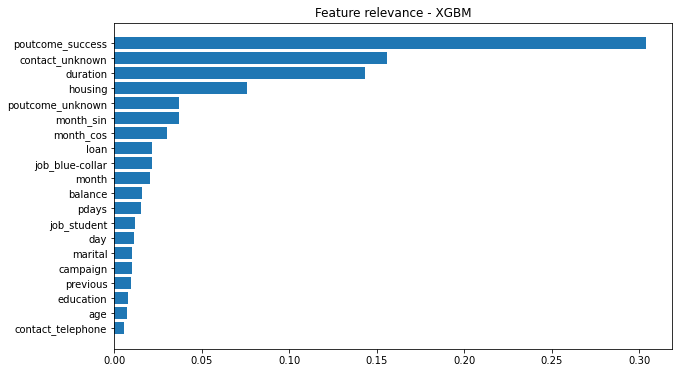

In [15]:
importances = final_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'feature': features,'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'][:20], feat_imp_df['importance'][:20])
plt.gca().invert_yaxis()
plt.title("Feature relevance - XGBM")
plt.show()

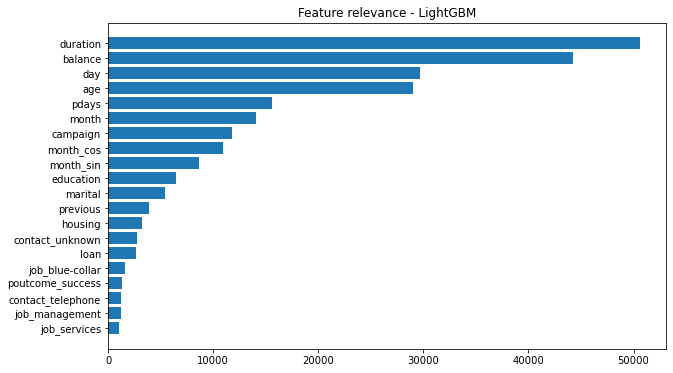

In [16]:
importances_lgb = final_model_lgb.feature_importances_
features = X.columns

feat_imp_df_lgb = pd.DataFrame({'feature': features,'importance': importances_lgb}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df_lgb['feature'][:20], feat_imp_df_lgb['importance'][:20])
plt.gca().invert_yaxis()
plt.title("Feature relevance - LightGBM")
plt.show()

In [17]:
voter.fit(X, y)

[LightGBM] [Info] Number of positive: 90488, number of negative: 659512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120651 -> initscore=-1.986283
[LightGBM] [Info] Start training from score -1.986283


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=0.85,
                                            colsample_bytree=0.75,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc',
                                            feature_types=None, gamma=None,
                                            gpu_id=None,
                                            grow_policy='lossguide',
                                            importance_type=None,
                                            interaction_constraints=None,
                                            lea...
                            

## Test prediction

In this section, I will use the trained final model for predicting if a given customer in the "test.csv" dataset will subscribe or not. This prediction will be then submitted to the official Kaggle competition.

In this current state, the score obtained in the Kaggle competition was 0.96933, which archive top 30% performance.

In [18]:
data_df = pd.read_csv("test.csv",  index_col="id")
print("Test shape", data_df.shape)

data_df = Binary_encoder(data_df, columns)
data_df = month_encoder(data_df)
data_df = pd.get_dummies(data_df, columns=["job", "contact", "poutcome"], drop_first=True, dtype=int)
data_df["education"] = data_df["education"].map(edu_map)
data_df["marital"] =  data_df["marital"].map(marital_map)

data_df.head()

Test shape (250000, 16)


,age,marital,education,default,balance,housing,loan,day,month,duration,...,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
id,,,,,,,,,,,,,,,,,,,,,
750000,32,1,1,0,1397,1,0,21,5.0,224,...,0,0,0,0,0,0,1,0,0,1
750001,44,1,2,0,23,1,0,3,4.0,586,...,0,0,0,0,0,0,0,0,0,1
750002,36,1,0,0,46,1,1,13,5.0,111,...,0,0,0,0,0,0,0,0,0,1
750003,58,1,1,0,-1380,1,1,29,5.0,125,...,0,0,0,0,0,0,1,0,0,1
750004,28,0,1,0,1950,1,0,22,7.0,181,...,0,0,1,0,0,0,0,0,0,1


In [19]:
X = data_df[X.columns]
y_pred_proba = voter.predict_proba(X)[:, 1]
print(y_pred_proba)

[0.0116114  0.4529783  0.0014046  ... 0.95045732 0.00653561 0.4654334 ]


### Submission file

In [20]:
sub_df = pd.read_csv("sample_submission.csv")
sub_df['y'] = y_pred_proba
sub_df.to_csv("sample_submission.csv", index=False)

*Reference*: www.kaggle.com/competitions/playground-series-s5e8. 
